### 读取数据

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer,OneHotEncoder,Imputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score,roc_curve, auc

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

data_original = pd.read_csv('data.csv', engine='python', skipinitialspace=True)
data = data_original.copy()
data.head(5)

,Unnamed: 0,custid,trade_no,bank_card_no,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,...,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
0,5,2791858,20180507115231274000000023057383,卡号1,0.01,0.99,0,0.90,0.55,0.313,...,2900.0,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0
1,10,534047,20180507121002192000000023073000,卡号1,0.02,0.94,2000,1.28,1.00,0.458,...,3500.0,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0
2,12,2849787,20180507125159718000000023114911,卡号1,0.04,0.96,0,1.00,1.00,0.114,...,1600.0,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0
3,13,1809708,20180507121358683000000388283484,卡号1,0.00,0.96,2000,0.13,0.57,0.777,...,3200.0,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0
4,14,2499829,20180507115448545000000388205844,卡号1,0.01,0.99,0,0.46,1.00,0.175,...,2300.0,1630.0,8300.0,79.0,2.0,2.0,8400.0,8250.0,22.0,120.0


### 删除无关项

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 90 columns):
Unnamed: 0                                    4754 non-null int64
custid                                        4754 non-null int64
trade_no                                      4754 non-null object
bank_card_no                                  4754 non-null object
low_volume_percent                            4752 non-null float64
middle_volume_percent                         4752 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4751 non-null float64
trans_activity_month                          4752 non-null float64
trans_activity_day                            4752 non-null float64
transd_mcc                                    4752 non-null float64
trans_days_interval_filter                    4746 non-null float64
trans_days_interval                           4752 non-null float64
regional_mobility

In [3]:
data.drop(['Unnamed: 0', 'custid', 'trade_no', 'bank_card_no', 'source','id_name'], axis=1, inplace=True)
object_cols = [col for col in data.columns if data[col].dtypes == 'O']
data_obj = data[object_cols]
data_num = data.drop(object_cols,axis=1)

### 缺失值补全

In [4]:
#缺失值填充
imputer=Imputer(strategy='mean')
mean_num=imputer.fit_transform(data_num)
data_num=pd.DataFrame(mean_num,columns=data_num.columns)
data_obj.ffill(inplace=True)
#One-HotEncoder
encoder = LabelBinarizer()
reg_preference_1hot = encoder.fit_transform(data_obj[['reg_preference_for_trad']])
data_obj.drop(['reg_preference_for_trad'], axis=1, inplace=True)
reg_preference_df = pd.DataFrame(reg_preference_1hot, columns=encoder.classes_)
data_obj = pd.concat([data_obj, reg_preference_df], axis=1)

#['latest_query_time']  ['loans_latest_time']
data_obj['latest_query_time'] = pd.to_datetime(data_obj['latest_query_time'])
data_obj['latest_query_time_month'] = data_obj['latest_query_time'].dt.month
data_obj['latest_query_time_weekday'] = data_obj['latest_query_time'].dt.weekday

data_obj['loans_latest_time'] = pd.to_datetime(data_obj['loans_latest_time'])
data_obj['loans_latest_time_month'] = data_obj['loans_latest_time'].dt.month
data_obj['loans_latest_time_weekday'] = data_obj['loans_latest_time'].dt.weekday

data_obj = data_obj.drop(['latest_query_time', 'loans_latest_time'], axis=1)

data=pd.concat([data_num,data_obj],axis=1)
data.shape

(4754, 90)

### 数据集切分

In [5]:
from sklearn.model_selection import train_test_split
y = data['status']
X = data.drop(['status'],axis=1)
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=2018)

### 性能评估

In [6]:
# 性能评估
from sklearn.metrics import accuracy_score, roc_auc_score

def model_metrics(clf, X_train, X_test, y_train, y_test):
    # 预测
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    y_train_proba = clf.predict_proba(X_train)[:,1]
    y_test_proba = clf.predict_proba(X_test)[:,1]
    
    # 准确率
    print('[准确率]', end = ' ')
    print('训练集：', '%.4f'%accuracy_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%accuracy_score(y_test, y_test_pred))
    
    # auc取值：用roc_auc_score或auc
    print('[auc值]', end = ' ')
    print('训练集：', '%.4f'%roc_auc_score(y_train, y_train_proba), end = ' ')
    print('测试集：', '%.4f'%roc_auc_score(y_test, y_test_proba))



In [7]:
def model_metrics(clf, X_train, X_test, y_train, y_test):
    # 预测训练集和测试集
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    y_train_proba = clf.predict_proba(X_train)[:,1]
    y_test_proba = clf.predict_proba(X_test)[:,1]
    
    # 准确率Accuracy
    print('[准确率]', end = ' ')
    print('训练集：', '%.4f'%accuracy_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%accuracy_score(y_test, y_test_pred))
    
    # 精准率Precision
    print('[精准率]', end = ' ')
    print('训练集：', '%.4f'%precision_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%precision_score(y_test, y_test_pred))

    # 召回率Recall
    print('[召回率]', end = ' ')
    print('训练集：', '%.4f'%recall_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%recall_score(y_test, y_test_pred))
    
    # f1-score
    print('[f1-score]', end = ' ')
    print('训练集：', '%.4f'%f1_score(y_train, y_train_pred), end = ' ')
    print('测试集：', '%.4f'%f1_score(y_test, y_test_pred))
    
    # AUC取值
    print('[auc值]', end = ' ')
    print('训练集：', '%.4f'%roc_auc_score(y_train, y_train_proba), end = ' ')
    print('测试集：', '%.4f'%roc_auc_score(y_test, y_test_proba))
    
    # ROC曲线
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_proba, pos_label = 1)
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba, pos_label = 1)
    
    label = ["Train - AUC:{:.4f}".format(auc(fpr_train, tpr_train)), 
             "Test - AUC:{:.4f}".format(auc(fpr_test, tpr_test))]
    plt.plot(fpr_train,tpr_train)
    plt.plot(fpr_test,tpr_test)
    plt.plot([0, 1], [0, 1], 'd--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(label, loc = 4)
    plt.title("ROC curve")

[准确率] 训练集： 0.4965 测试集： 0.5102
[精准率] 训练集： 0.2820 测试集： 0.2952
[召回率] 训练集： 0.6523 测试集： 0.6825
[f1-score] 训练集： 0.3938 测试集： 0.4121
[auc值] 训练集： 0.5874 测试集： 0.5810


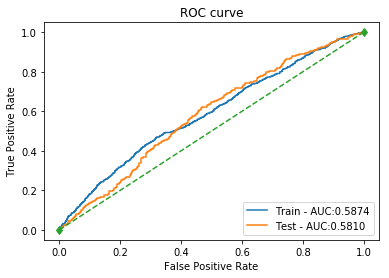

In [8]:
#构架模型并评价
from sklearn.linear_model import LogisticRegressionCV

clf=LogisticRegressionCV(class_weight='balanced',max_iter=5000)
clf.fit(X_train,y_train)
model_metrics(clf, X_train, X_test, y_train, y_test)

## IV值

In [9]:
import math
from scipy import stats
from sklearn.utils.multiclass import type_of_target

def woe(X, y, event=1):  
    res_woe = []
    iv_dict = {}
    for feature in X.columns:
        x = X[feature].values
        # 1) 连续特征离散化
        if type_of_target(x) == 'continuous':
            x = discrete(x)
        # 2) 计算该特征的woe和iv
        # woe_dict, iv = woe_single_x(x, y, feature, event)
        woe_dict, iv = woe_single_x(x, y, feature, event)
        iv_dict[feature] = iv
        res_woe.append(woe_dict) 
        
    return iv_dict
        
def discrete(x):
    # 使用5等分离散化特征
    res = np.zeros(x.shape)
    for i in range(5):
        point1 = stats.scoreatpercentile(x, i * 20)
        point2 = stats.scoreatpercentile(x, (i + 1) * 20)
        x1 = x[np.where((x >= point1) & (x <= point2))]
        mask = np.in1d(x, x1)
        res[mask] = i + 1    # 将[i, i+1]块内的值标记成i+1
    return res

def woe_single_x(x, y, feature,event = 1):
    # event代表预测正例的标签
    event_total = sum(y == event)
    non_event_total = y.shape[-1] - event_total
    
    iv = 0
    woe_dict = {}
    for x1 in set(x):    # 遍历各个块
        y1 = y.reindex(np.where(x == x1)[0])
        event_count = sum(y1 == event)
        non_event_count = y1.shape[-1] - event_count
        rate_event = event_count / event_total    
        rate_non_event = non_event_count / non_event_total
        
        if rate_event == 0:
            rate_event = 0.0001
            # woei = -20
        elif rate_non_event == 0:
            rate_non_event = 0.0001
            # woei = 20
        woei = math.log(rate_event / rate_non_event)
        woe_dict[x1] = woei
        iv += (rate_event - rate_non_event) * woei
    return woe_dict, iv

In [10]:
iv_dict = woe(X_train, y_train)
iv = sorted(iv_dict.items(), key = lambda x:x[1],reverse = True)
iv

[('historical_trans_amount', 2.6609646134512865),
 ('trans_amount_3_month', 2.5546436077538357),
 ('repayment_capability', 2.327229251967252),
 ('pawns_auctions_trusts_consume_last_6_month', 2.220777389641486),
 ('abs', 1.966985825643712),
 ('max_cumulative_consume_later_1_month', 1.4598660465564153),
 ('pawns_auctions_trusts_consume_last_1_month', 0.8530625616084101),
 ('avg_price_last_12_month', 0.7281431950917352),
 ('take_amount_in_later_12_month_highest', 0.4407207265219969),
 ('latest_query_time_month', 0.25139126628755865),
 ('loans_latest_time_weekday', 0.24326338644309412),
 ('history_fail_fee', 0.23601952893571299),
 ('loans_latest_time_month', 0.23316679232272933),
 ('latest_query_day', 0.23165030755336188),
 ('history_suc_fee', 0.23132587006862826),
 ('trans_days_interval', 0.23127346695672282),
 ('trans_activity_day', 0.23089021521474926),
 ('latest_six_month_apply', 0.23004076549705482),
 ('apply_score', 0.22999736959648898),
 ('loans_avg_limit', 0.22937233933022275),
 ('

In [11]:
threshold = 0.1
data_index = []
for i in range(len(iv)):
    if iv[i][1] < threshold:
        data_index.append(iv[i])
        print(iv[i])
#X_train.drop(data_index, axis=1, inplace=True)


## 使用随机森林选择特征

袋外分数： 0.7868951006913135
[准确率] 训练集： 0.8200 测试集： 0.7800
[精准率] 训练集： 0.9038 测试集： 0.7228
[召回率] 训练集： 0.3153 测试集： 0.2033
[f1-score] 训练集： 0.4676 测试集： 0.3174
[auc值] 训练集： 0.9010 测试集： 0.7686


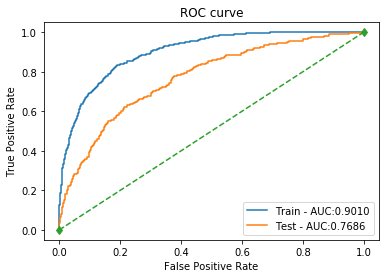

In [12]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=120, max_depth=9, min_samples_split=50,
                            min_samples_leaf=20, max_features = 9,oob_score=True, random_state=2333)
rf.fit(X_train, y_train)
print('袋外分数：', rf.oob_score_)
model_metrics(rf, X_train, X_test, y_train, y_test)
feature_importance1 = sorted(zip(map(lambda x: '%.4f'%x, rf.feature_importances_), list(X_train.columns)), reverse=True)

In [13]:
feature_importance1

[('0.1361', 'trans_fail_top_count_enum_last_1_month'),
 ('0.0933', 'history_fail_fee'),
 ('0.0779', 'loans_score'),
 ('0.0513', 'loans_overdue_count'),
 ('0.0508', 'apply_score'),
 ('0.0379', 'latest_one_month_fail'),
 ('0.0365', 'trans_fail_top_count_enum_last_6_month'),
 ('0.0284', 'trans_fail_top_count_enum_last_12_month'),
 ('0.0199', 'trans_day_last_12_month'),
 ('0.0191', 'latest_one_month_suc'),
 ('0.0180', 'max_cumulative_consume_later_1_month'),
 ('0.0142', 'consfin_avg_limit'),
 ('0.0140', 'rank_trad_1_month'),
 ('0.0132', 'trans_amount_3_month'),
 ('0.0128', 'consume_top_time_last_1_month'),
 ('0.0125', 'latest_query_day'),
 ('0.0109', 'historical_trans_amount'),
 ('0.0099', 'trans_top_time_last_1_month'),
 ('0.0099', 'trans_activity_day'),
 ('0.0099', 'historical_trans_day'),
 ('0.0098', 'history_suc_fee'),
 ('0.0094', 'first_transaction_time'),
 ('0.0090', 'loans_latest_day'),
 ('0.0090', 'consfin_credit_limit'),
 ('0.0085', 'loans_count'),
 ('0.0084', 'loans_settle_count'

In [14]:
X_train.head(5)

,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,student_feature,repayment_capability,is_high_user,number_of_trans_from_2011,first_transaction_time,historical_trans_amount,historical_trans_day,rank_trad_1_month,trans_amount_3_month,avg_consume_less_12_valid_month,abs,top_trans_count_last_1_month,avg_price_last_12_month,avg_price_top_last_12_valid_month,trans_top_time_last_1_month,trans_top_time_last_6_month,consume_top_time_last_1_month,consume_top_time_last_6_month,cross_consume_count_last_1_month,trans_fail_top_count_enum_last_1_month,trans_fail_top_count_enum_last_6_month,trans_fail_top_count_enum_last_12_month,consume_mini_time_last_1_month,max_cumulative_consume_later_1_month,max_consume_count_later_6_month,railway_consume_count_last_12_month,pawns_auctions_trusts_consume_last_1_month,pawns_auctions_trusts_consume_last_6_month,jewelry_consume_count_last_6_month,first_transaction_day,trans_day_last_12_month,apply_score,apply_credibility,query_org_count,query_finance_count,query_cash_count,query_sum_count,latest_one_month_apply,latest_three_month_apply,latest_six_month_apply,loans_score,loans_credibility_behavior,loans_count,loans_settle_count,loans_overdue_count,loans_org_count_behavior,consfin_org_count_behavior,loans_cash_count,latest_one_month_loan,latest_three_month_loan,latest_six_month_loan,history_suc_fee,history_fail_fee,latest_one_month_suc,latest_one_month_fail,loans_long_time,loans_credit_limit,loans_credibility_limit,loans_org_count_current,loans_product_count,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day,一线城市,三线城市,二线城市,其他城市,境外,latest_query_time_month,latest_query_time_weekday,loans_latest_time_month,loans_latest_time_weekday
110,0.01,0.99,4000.0,0.96,1.00,0.405,16.0,29.0,28.0,1.0,1.000000,17570.0,0.0,13.0,20170217.0,181770.0,150.0,0.85,15610.0,7.0,2650.0,1.00,1220.0,0.45,0.0,29.0,0.0,29.0,0.0,6.0,9.0,9.0,0.0,220.0,6.0,0.0,0.0,10160.0,0.0,458.0,99.0,535.0,73.0,16.0,6.0,7.0,24.0,5.0,12.0,15.0,498.0,73.0,92.0,77.0,7.0,27.0,7.0,20.0,1.0,3.0,34.0,85.0,52.0,0.0,3.0,356.0,2400.0,72.0,20.0,22.0,5000.0,1845.0,10600.0,81.0,7.0,7.0,15600.0,8228.0,0.0,9.0,1,0,0,0,0,5,4,4,2
3394,0.03,0.97,500.0,0.87,1.00,0.205,18.0,27.0,27.0,3.0,1.001139,15310.0,0.0,12.0,20170331.0,63350.0,74.0,0.65,12200.0,6.0,3460.0,0.40,630.0,0.65,14.0,17.0,14.0,17.0,1.0,1.0,4.0,9.0,0.0,470.0,4.0,0.0,470.0,2060.0,0.0,416.0,82.0,540.0,81.0,8.0,3.0,3.0,9.0,1.0,3.0,6.0,510.0,76.0,19.0,16.0,3.0,7.0,5.0,2.0,1.0,1.0,5.0,22.0,11.0,1.0,0.0,357.0,2400.0,73.0,2.0,2.0,2600.0,1800.0,16300.0,78.0,5.0,5.0,21600.0,7160.0,30.0,27.0,1,0,0,0,0,4,5,4,1
3052,0.02,0.86,0.0,1.98,0.70,0.205,18.0,53.0,33.0,2.0,1.001139,12240.0,0.0,28.0,20141110.0,97190.0,93.0,0.45,33280.0,8.0,1060.0,0.30,930.0,0.55,11.0,21.0,11.0,21.0,0.0,0.0,4.0,21.0,0.0,1950.0,12.0,0.0,1950.0,8240.0,0.0,1288.0,82.0,516.0,75.0,14.0,8.0,6.0,19.0,5.0,8.0,12.0,482.0,77.0,16.0,16.0,2.0,8.0,5.0,3.0,0.0,0.0,7.0,20.0,5.0,0.0,0.0,314.0,1400.0,66.0,3.0,3.0,2300.0,1500.0,10400.0,82.0,5.0,5.0,13800.0,10320.0,3.0,137.0,1,0,0,0,0,5,4,12,3
490,0.02,0.81,1000.0,1.49,0.73,0.555,23.0,15.0,8.0,4.0,1.000000,4320.0,0.0,40.0,20130817.0,373700.0,356.0,0.30,61940.0,8.0,26200.0,0.10,1390.0,0.45,15.0,15.0,15.0,15.0,1.0,8.0,8.0,8.0,42936.0,3090.0,7.0,0.0,3140.0,67720.0,0.0,1738.0,82.0,491.0,74.0,11.0,6.0,4.0,12.0,1.0,4.0,7.0,448.0,78.0,40.0,22.0,7.0,17.0,11.0,6.0,0.0,3.0,18.0,40.0,78.0,0.0,10.0,356.0,2600.0,76.0,6.0,7.0,4500.0,2500.0,6600.0,78.0,11.0,12.0,17400.0,6418.0,20.0,51.0,0,1,0,0,0,4,1,3,5
1,0.02,0.94,2000.0,1.28,1.00,0.458,19.0,30.0,14.0,4.0,1.000000,16970.0,0.0,23.0,20160402.0,302910.0,224.0,0.35,10590.0,5.0,6950.0,0.05,1210.0,0.50,13.0,30.0,13.0,30.0,0.0,0.0,3.0,3.0,330.0,2100.0,9.0,0.0,1820.0,15680.0,0.

In [15]:
useless=[]
for feature in X_train.columns:
    if feature in [t[1] for t in feature_importance1[30:]]:
        useless.append(feature)

In [16]:
X_train.drop(useless, axis = 1, inplace = True)
X_test.drop(useless, axis = 1, inplace = True)

###  模型构建


In [17]:
#数据归一化评价
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,roc_curve

lr = LogisticRegression(C = 0.1, penalty = 'l1')
svm_linear = svm.SVC(C = 0.01, kernel = 'linear', probability=True)
svm_poly =  svm.SVC(C = 0.01, kernel = 'poly', probability=True)
svm_rbf =  svm.SVC(gamma = 0.01, C =0.01 , probability=True)
svm_sigmoid =  svm.SVC(C = 0.01, kernel = 'sigmoid',probability=True)
dt = DecisionTreeClassifier(max_depth=5,min_samples_split=50,min_samples_leaf=60, max_features=9, random_state =2018)
clf = RandomForestClassifier(max_depth=2, random_state=2018)
xgb = XGBClassifier(learning_rate =0.1, n_estimators=80, max_depth=3, min_child_weight=5,\
                    gamma=0.2, subsample=0.8, colsample_bytree=0.8, reg_alpha=1e-5,\
                    objective= 'binary:logistic', nthread=4,scale_pos_weight=1, seed=27)

#### 逻辑回归

[准确率] 训练集： 0.8031 测试集： 0.7870
[精准率] 训练集： 0.7277 测试集： 0.6708
[召回率] 训练集： 0.3429 测试集： 0.3008
[f1-score] 训练集： 0.4662 测试集： 0.4154
[auc值] 训练集： 0.8034 测试集： 0.7855


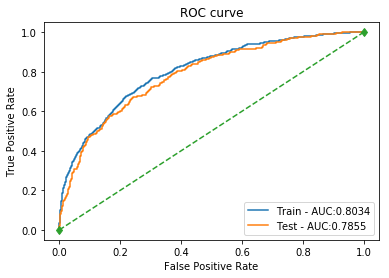

In [19]:
lr.fit(X_train, y_train.values)
model_metrics(lr, X_train, X_test, y_train, y_test)

### SVM

[准确率] 训练集： 0.7923 测试集： 0.7744
[精准率] 训练集： 0.7942 测试集： 0.7079
[召回率] 训练集： 0.2314 测试集： 0.1755
[f1-score] 训练集： 0.3584 测试集： 0.2812
[auc值] 训练集： 0.8070 测试集： 0.7896


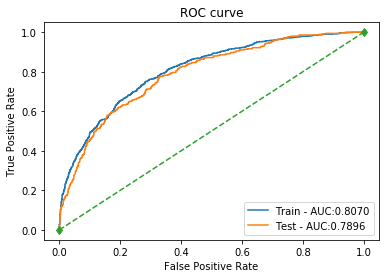

In [20]:
svm_linear.fit(X_train, y_train.values)
model_metrics(svm_linear, X_train, X_test, y_train, y_test)

[准确率] 训练集： 0.7598 测试集： 0.7582
[精准率] 训练集： 0.8723 测试集： 0.8500
[召回率] 训练集： 0.0492 测试集： 0.0474
[f1-score] 训练集： 0.0931 测试集： 0.0897
[auc值] 训练集： 0.8204 测试集： 0.7646


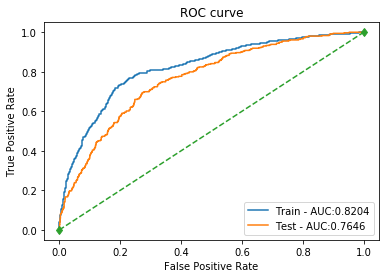

In [21]:
svm_poly.fit(X_train, y_train.values)
model_metrics(svm_poly, X_train, X_test, y_train, y_test)

[准确率] 训练集： 0.7493 测试集： 0.7484
[精准率] 训练集： 0.0000 测试集： 0.0000
[召回率] 训练集： 0.0000 测试集： 0.0000
[f1-score] 训练集： 0.0000 测试集： 0.0000
[auc值] 训练集： 0.8077 测试集： 0.7807


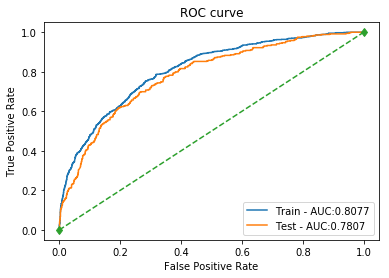

In [22]:
svm_rbf.fit(X_train, y_train.values)
model_metrics(svm_rbf, X_train, X_test, y_train, y_test)

[准确率] 训练集： 0.7493 测试集： 0.7484
[精准率] 训练集： 0.0000 测试集： 0.0000
[召回率] 训练集： 0.0000 测试集： 0.0000
[f1-score] 训练集： 0.0000 测试集： 0.0000
[auc值] 训练集： 0.7975 测试集： 0.7799


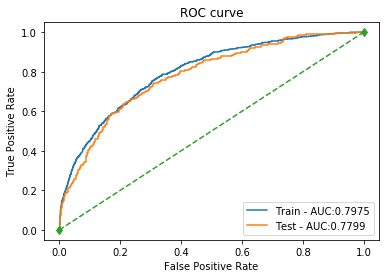

In [23]:
svm_sigmoid.fit(X_train, y_train.values)
model_metrics(svm_sigmoid, X_train, X_test, y_train, y_test)

#### 决策树

[准确率] 训练集： 0.7950 测试集： 0.7645
[精准率] 训练集： 0.6617 测试集： 0.5525
[召回率] 训练集： 0.3729 测试集： 0.3370
[f1-score] 训练集： 0.4770 测试集： 0.4187
[auc值] 训练集： 0.7805 测试集： 0.7177


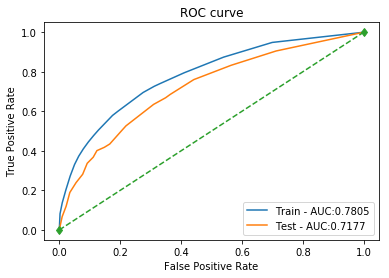

In [24]:
dt.fit(X_train, y_train.values)
model_metrics(dt, X_train, X_test, y_train, y_test)

#### 随机森林

[准确率] 训练集： 0.7746 测试集： 0.7744
[精准率] 训练集： 0.8387 测试集： 0.8246
[召回率] 训练集： 0.1247 测试集： 0.1309
[f1-score] 训练集： 0.2171 测试集： 0.2260
[auc值] 训练集： 0.7668 测试集： 0.7413


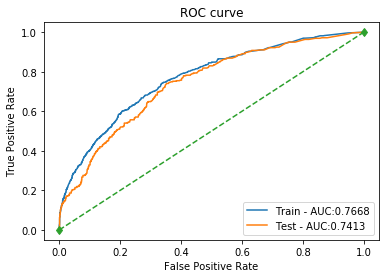

In [25]:
clf.fit(X_train, y_train.values)
model_metrics(clf, X_train, X_test, y_train, y_test)

#### XGBoost

[准确率] 训练集： 0.8380 测试集： 0.7912
[精准率] 训练集： 0.8105 测试集： 0.6488
[召回率] 训练集： 0.4616 测试集： 0.3705
[f1-score] 训练集： 0.5882 测试集： 0.4716
[auc值] 训练集： 0.8751 测试集： 0.7844


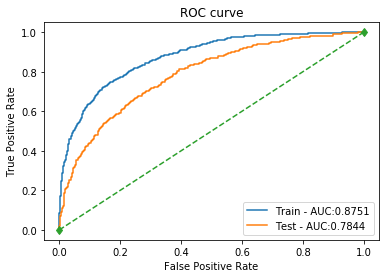

In [26]:
xgb.fit(X_train, y_train.values)
model_metrics(xgb, X_train, X_test, y_train, y_test)

## 结果

|模型|参数|准确率|精确率|召回率|F1-Score|AUC取值|ROC曲线
|:---|:---|:---|:---|:---|:---|:---||:---|
|LR逻辑回归|LogisticRegression(C = 0.1, penalty = 'l1')| 训练集： 0.8031 测试集： 0.7877|训练集： 0.7277 测试集： 0.6750|训练集： 0.3429 测试集： 0.3008|训练集： 0.4662 测试集： 0.4162| 训练集： 0.8034 测试集： 0.7855|<img align="right" style="padding-right:1px;" src="ROC-LR.png">|
|svm_linear|svm.SVC(C = 0.01, kernel = 'linear', probability=True)|训练集： 0.7923 测试集： 0.7744| 训练集： 0.7942 测试集： 0.7079| 训练集： 0.2314 测试集： 0.1755| 训练集： 0.3584 测试集： 0.2812| 训练集： 0.8070 测试集： 0.7897|<img align="right" style="padding-right:1px;" src="ROC-LINEAR.png">|
|svm_poly|svm.SVC(C = 0.01, kernel = 'poly', probability=True)| 训练集： 0.7598 测试集： 0.7582| 训练集： 0.8723 测试集： 0.8500| 训练集： 0.0492 测试集： 0.0474| 训练集： 0.0931 测试集： 0.0897| 训练集： 0.8204 测试集： 0.7646| <img align="right" style="padding-right:1px;" src="ROC-POLY.png">|
|svm_rbf|svm.SVC(gamma = 0.01, C =0.01 , probability=True)| 训练集： 0.7493 测试集： 0.7484| 训练集： 0.0000 测试集： 0.0000| 训练集： 0.0000 测试集： 0.0000| 训练集： 0.0000 测试集： 0.0000| 训练集： 0.8077 测试集： 0.7806| <img align="right" style="padding-right:1px;" src="ROC-RBF.png">|
|svm_sigmoid|svm.SVC(C = 0.01, kernel = 'sigmoid',probability=True)| 训练集： 0.7493 测试集： 0.7484| 训练集： 0.0000 测试集： 0.0000| 训练集： 0.0000 测试集： 0.0000| 训练集： 0.0000 测试集： 0.0000| 训练集： 0.7975 测试集： 0.7800|<img align="right" style="padding-right:1px;" src="ROC-SIGMOID.png">|
|决策树|DecisionTreeClassifier(max_depth=11,min_samples_split=550,min_samples_leaf=80,max_features=19)| 训练集： 0.7950 测试集： 0.7645| 训练集： 0.6617 测试集： 0.5525| 训练集： 0.3729 测试集： 0.3370| 训练集： 0.4770 测试集： 0.4187| 训练集： 0.7805 测试集： 0.7177| <img align="right" style="padding-right:1px;" src="ROC-DT.png">|
|随机森林|RandomForestClassifier(max_depth=2, random_state=2018)| 训练集： 0.7746 测试集： 0.7744| 训练集： 0.8387 测试集： 0.8246| 训练集： 0.1247 测试集： 0.1309| 训练集： 0.2171 测试集： 0.2260| 训练集： 0.7668 测试集： 0.7413| <img align="right" style="padding-right:1px;" src="ROC-RF.png">|
|XGBoost|XGBClassifier(learning_rate =0.01, n_estimators=180, max_depth=3, min_child_weight=5,gamma=0.4, subsample=0.5, colsample_bytree=0.9, reg_alpha=1, objective= 'binary:logistic',nthread=4,scale_pos_weight=1, seed=27)| 训练集： 0.8380 测试集： 0.7912| 训练集： 0.8105 测试集： 0.6488| 训练集： 0.4616 测试集： 0.3705| 训练集： 0.5882 测试集： 0.4716| 训练集： 0.8751 测试集： 0.7844|<img align="right" style="padding-right:1px;" src="ROC-XGBOOST.png">|

### Reference
https://blog.csdn.net/zhangyunpeng0922/article/details/84591046<br/>
https://blog.csdn.net/wxq_1993/article/details/86695650